# Week 3: Using RNNs to predict time series

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

2024-07-12 07:34:14.099689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 07:34:14.099873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 07:34:14.268945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Generating the data

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

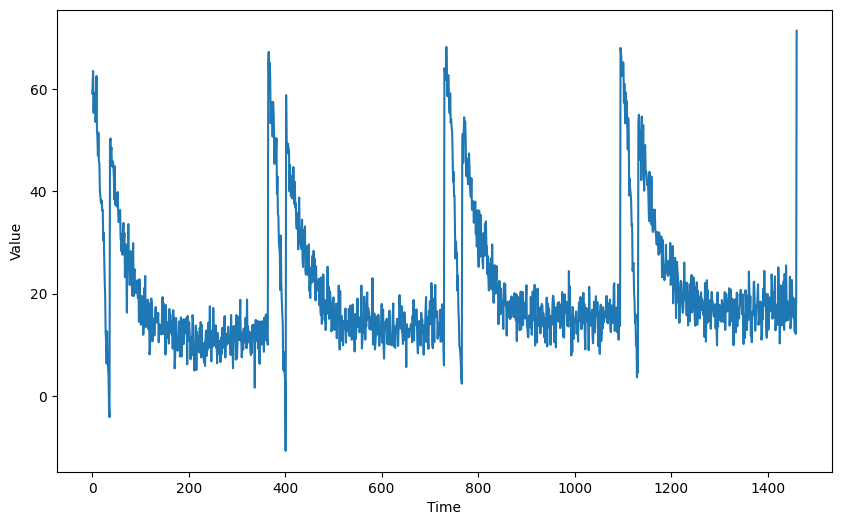

In [4]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [5]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [6]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

In [7]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    ### END CODE HERE

    return model

In [8]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Your current architecture is compatible with the windowed dataset! :)


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Adjusting the learning rate - (Optional Exercise)

In [9]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber,
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [10]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 6.4293 - mae: 6.9077 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7050 - mae: 5.1678 - learning_rate: 1.1220e-06
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.0299 - mae: 5.4934 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5420 - mae: 5.0048 - learning_rate: 1.4125e-06
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5449 - mae: 5.0058 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.6062 - mae: 5.0624 - learning_rate: 1.7783e-06
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3417 - mae: 4.8055 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5904 - mae: 5.0544 - learning_rate: 2.2387e-06
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4569 - mae: 4.9236 - learning_rate: 2.5119e-06
Epoch 10/100
34/34 

(1e-06, 1.0, 0.0, 30.0)

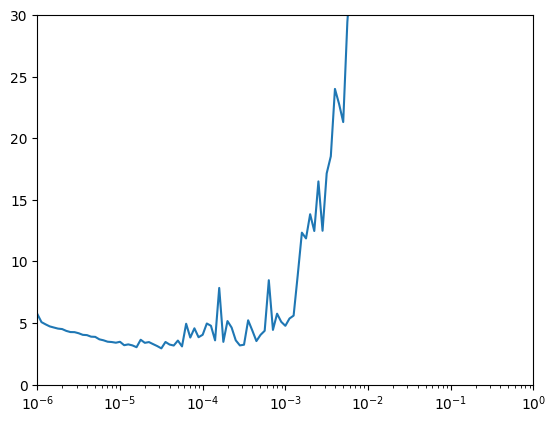

In [12]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

In [23]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE
    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber,
                  optimizer=optimizer,
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [24]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 9.2867 - mae: 9.7711
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.5098 - mae: 3.9793
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.6879 - mae: 4.1531
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8837 - mae: 4.3468
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.8135 - mae: 4.2721
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.6471 - mae: 4.1070
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7139 - mae: 4.1791
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.5708 - mae: 4.0303
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.3281 - mae: 3.7881
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.0473 - mae: 3.5066
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1753 - mae: 3.6372
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.4631 - mae: 3.9172
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━

## Evaluating the forecast

In [25]:
def compute_metrics(true_series, forecast):
    ### START CODE HERE
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mse_result = mse.result().numpy()
    
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    mae_result = mae.result().numpy()
    ### END CODE HERE

    return mse_result, mae_result

## Faster model forecasts

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


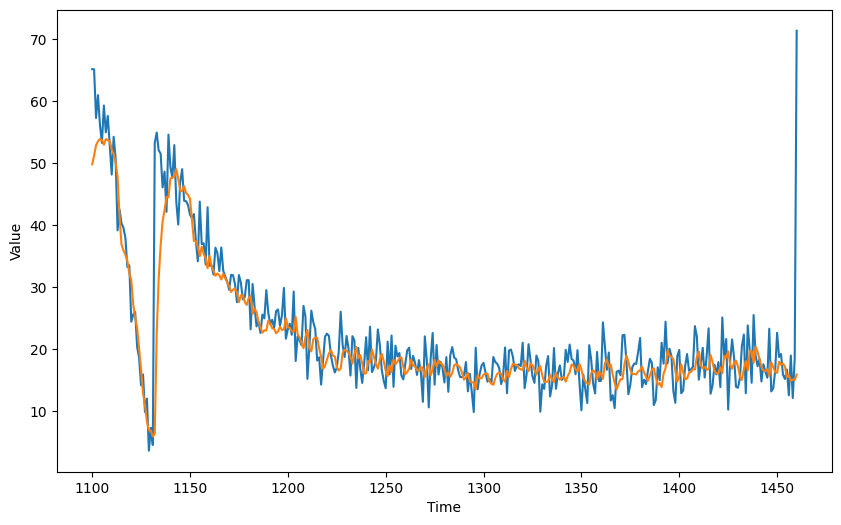

In [27]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 33.06, mae: 3.32 for forecast
